<a href="https://colab.research.google.com/github/Mafia-Deadend/WBAN-CRYPTOGRAPHY-USING-EDWARD-CURVE/blob/main/Cryptography_ECC_and_Edward_Curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas matplotlib pycryptodome tinyec pynacl


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 21.9 MB/s eta 0:00:00
  Created wheel for tinyec: filename=tinyec-0.4.0-py3-none-any.whl size=20877 sha256=49346b897027ca7071570ec72c4aed3c677691b750dd9917a1e3bb3bfa574d59
  Stored in directory: /root/.cache/pip/wheels/02/37/a5/aa011cfa66451de6aa2dbccaa3e7862e8290f0946653753265
Successfully built tinyec


## Reading Data from CSV file of real case scenario

Packet successfully delivered.
Packet successfully delivered.
Packet successfully delivered.
Packet successfully delivered.
Packet successfully delivered.
Packet successfully delivered.
Packet successfully delivered.
Packet successfully delivered.
Results for data sample 1:
ECC Encryption Time: 0.070301 seconds
Edwards Curve Encryption Time: 0.000153 seconds
Edwards Curve Decryption Time: 0.000161 seconds
ECC Decryption Time: 0.036944 seconds
Results for data sample 2:
ECC Encryption Time: 0.067787 seconds
Edwards Curve Encryption Time: 0.000124 seconds
Edwards Curve Decryption Time: 0.000072 seconds
ECC Decryption Time: 0.034865 seconds
Results for data sample 3:
ECC Encryption Time: 0.077859 seconds
Edwards Curve Encryption Time: 0.000112 seconds
Edwards Curve Decryption Time: 0.000072 seconds
ECC Decryption Time: 0.036632 seconds
Results for data sample 4:
ECC Encryption Time: 0.068701 seconds
Edwards Curve Encryption Time: 0.000107 seconds
Edwards Curve Decryption Time: 0.000071 se

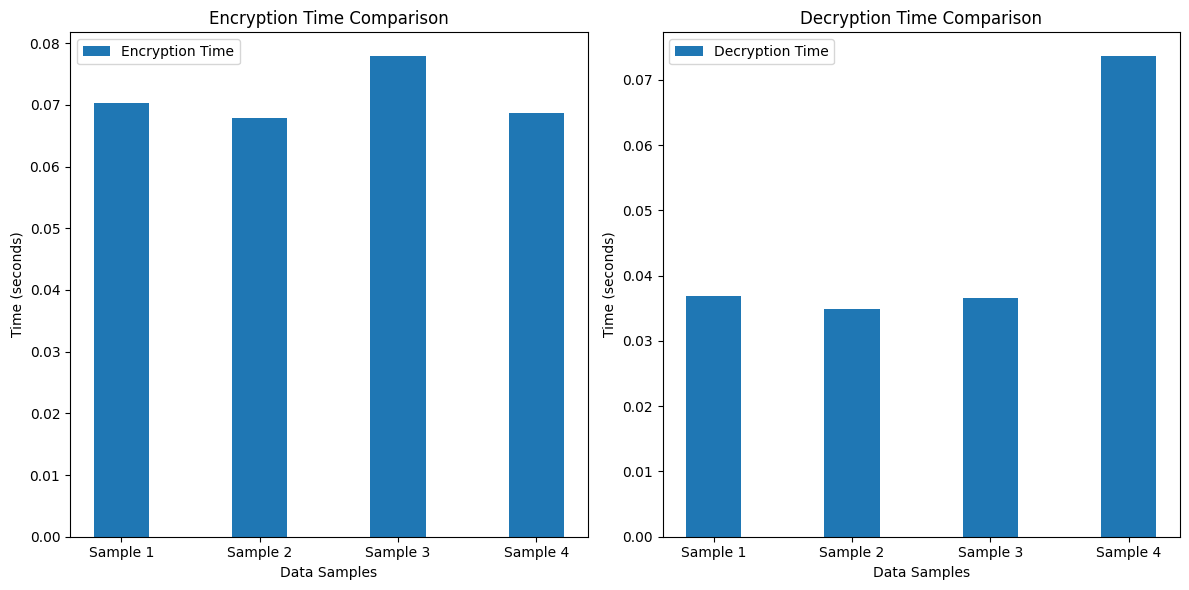

In [ ]:
import time
import random
import matplotlib.pyplot as plt
from tinyec import registry
from Crypto.Cipher import AES
import hashlib, secrets
from nacl.public import PrivateKey, Box
import pandas as pd
import numpy as np

# Simulate network metrics
def simulate_network_latency():
    latency = random.uniform(0.01, 0.1)  # Simulate latency between 10 to 100 milliseconds
    time.sleep(latency)

def simulate_network_jitter():
    base_latency = 0.05  # Average latency
    jitter = random.uniform(-0.01, 0.01)  # Jitter variation
    latency = base_latency + jitter
    time.sleep(latency)

def simulate_network_congestion():
    loss_rate = 0.05  # 5% packet loss rate
    is_packet_lost = random.random() < loss_rate
    if is_packet_lost:
        print("Packet lost due to congestion.")
        return False
    else:
        print("Packet successfully delivered.")
        return True

# ECC Encryption/Decryption
curve = registry.get_curve('brainpoolP256r1')

def ecc_encrypt(msg, pub_key):
    priv_key = secrets.randbelow(curve.field.n)
    shared_key = priv_key * pub_key
    secret_key = hashlib.sha256(int.to_bytes(shared_key.x, 32, 'big') + int.to_bytes(shared_key.y, 32, 'big')).digest()
    aes_cipher = AES.new(secret_key, AES.MODE_GCM)
    ciphertext, auth_tag = aes_cipher.encrypt_and_digest(msg)
    return (ciphertext, aes_cipher.nonce, auth_tag, priv_key * curve.g)

def ecc_decrypt(encrypted_msg, priv_key):
    ciphertext, nonce, auth_tag, pub_key = encrypted_msg
    shared_key = priv_key * pub_key
    secret_key = hashlib.sha256(int.to_bytes(shared_key.x, 32, 'big') + int.to_bytes(shared_key.y, 32, 'big')).digest()
    aes_cipher = AES.new(secret_key, AES.MODE_GCM, nonce)
    plaintext = aes_cipher.decrypt_and_verify(ciphertext, auth_tag)
    return plaintext

# Edwards Curve Encryption/Decryption
def edwards_encrypt(message, public_key, private_key):
    box = Box(private_key, public_key)
    encrypted = box.encrypt(message)
    return encrypted

def edwards_decrypt(encrypted_msg, private_key, public_key):
    box = Box(private_key, public_key)
    decrypted = box.decrypt(encrypted_msg)
    return decrypted

# Function to perform encryption and decryption with timing and network simulation
def perform_encryption_decryption(data):
    message = str(data).encode()  # Convert data to string and then to bytes

    # ECC Encryption
    ecc_private_key = secrets.randbelow(curve.field.n)
    ecc_public_key = ecc_private_key * curve.g
    start_time = time.time()
    ecc_encrypted = ecc_encrypt(message, ecc_public_key)
    ecc_encryption_time = time.time() - start_time

    # Simulate network conditions
    simulate_network_latency()
    simulate_network_jitter()
    if not simulate_network_congestion():
        return None  # Skip this iteration if packet is lost

    # Edwards Curve Encryption
    ed_private_key = PrivateKey.generate()
    ed_public_key = ed_private_key.public_key
    start_time = time.time()
    ed_encrypted = edwards_encrypt(ecc_encrypted[0], ed_public_key, ed_private_key)
    ed_encryption_time = time.time() - start_time

    # Decrypt with Edwards Curve
    start_time = time.time()
    ed_decrypted = edwards_decrypt(ed_encrypted, ed_private_key, ed_public_key)
    ed_decryption_time = time.time() - start_time

    # Simulate network conditions
    simulate_network_latency()
    simulate_network_jitter()
    if not simulate_network_congestion():
        return None  # Skip this iteration if packet is lost

    # Decrypt with ECC
    start_time = time.time()
    ecc_decrypted = ecc_decrypt((ed_decrypted, ecc_encrypted[1], ecc_encrypted[2], ecc_encrypted[3]), ecc_private_key)
    ecc_decryption_time = time.time() - start_time

    # Return encryption and decryption times
    return {
        'ECC Encryption Time': ecc_encryption_time,
        'Edwards Curve Encryption Time': ed_encryption_time,
        'Edwards Curve Decryption Time': ed_decryption_time,
        'ECC Decryption Time': ecc_decryption_time,
    }

# Read data from CSV file
csv_file_path = 'heart.csv'  # Replace with your CSV file path
df = pd.read_csv(csv_file_path)

# Ensure the CSV has a 'data_column' column
if 'trestbps' not in df.columns:
    raise ValueError("CSV file must contain a column named 'trestbps'")

# Perform tests and collect results
results = []
for index, row in df.iterrows():
    data = row['trestbps']
    result = perform_encryption_decryption(data)
    if result:
        results.append(result)

# Print results
for idx, result in enumerate(results):
    print(f"Results for data sample {idx + 1}:")
    for key, value in result.items():
        print(f"{key}: {value:.6f} seconds")

# Plotting results
labels = ['ECC Encryption', 'Edwards Curve Encryption', 'Edwards Curve Decryption', 'ECC Decryption']
encryption_times = [result['ECC Encryption Time'] for result in results]
decryption_times = [result['ECC Decryption Time'] for result in results]

x = range(len(results))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(x, encryption_times, width=0.4, label='Encryption Time')
plt.xticks(x, [f'Sample {i + 1}' for i in x])
plt.xlabel('Data Samples')
plt.ylabel('Time (seconds)')
plt.title('Encryption Time Comparison')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(x, decryption_times, width=0.4, label='Decryption Time')
plt.xticks(x, [f'Sample {i + 1}' for i in x])
plt.xlabel('Data Samples')
plt.ylabel('Time (seconds)')
plt.title('Decryption Time Comparison')
plt.legend()

plt.tight_layout()
plt.show()


## Encrypt and Decrypt data Of Different sizes i.e 3kb,5kb,8kb,12kb,16kb


Results for 2 KB data:
ECC Encryption Time: 0.067249 seconds
Edwards Curve Encryption Time: 0.000183 seconds
Edwards Curve Decryption Time: 0.000119 seconds
ECC Decryption Time: 0.037075 seconds
Results for 4 KB data:
ECC Encryption Time: 0.069147 seconds
Edwards Curve Encryption Time: 0.000118 seconds
Edwards Curve Decryption Time: 0.000076 seconds
ECC Decryption Time: 0.035231 seconds
Results for 7 KB data:
ECC Encryption Time: 0.082474 seconds
Edwards Curve Encryption Time: 0.000113 seconds
Edwards Curve Decryption Time: 0.000081 seconds
ECC Decryption Time: 0.036953 seconds
Results for 15 KB data:
ECC Encryption Time: 0.126263 seconds
Edwards Curve Encryption Time: 0.000180 seconds
Edwards Curve Decryption Time: 0.000174 seconds
ECC Decryption Time: 0.071728 seconds


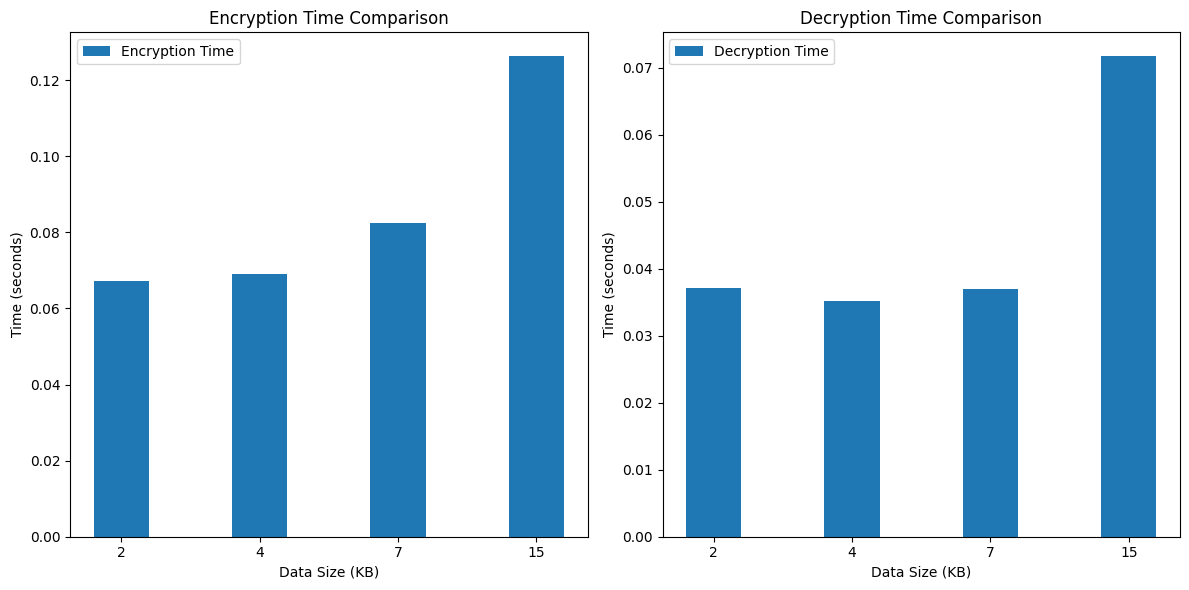

In [ ]:
import time
import random
import matplotlib.pyplot as plt
from Crypto.PublicKey import RSA
from Crypto.Cipher import PKCS1_OAEP
from tinyec import registry
from Crypto.Cipher import AES
import hashlib, secrets, binascii
import nacl.public
import nacl.utils
from nacl.public import PrivateKey, Box




# Simulate network metrics
def simulate_network_latency():
    latency = random.uniform(0.01, 0.1)  # Simulate latency between 10 to 100 milliseconds
    time.sleep(latency)

def simulate_network_jitter():
    base_latency = 0.05  # Average latency
    jitter = random.uniform(-0.01, 0.01)  # Jitter variation
    latency = base_latency + jitter
    time.sleep(latency)

def simulate_network_congestion():
    loss_rate = 0.05  # 5% packet loss rate
    is_packet_lost = random.random() < loss_rate
    if is_packet_lost:
        print("Packet lost due to congestion.")
    else:
        print("Packet successfully delivered.")






# ECC Encryption/Decryption
curve = registry.get_curve('brainpoolP256r1')

def ecc_encrypt(msg, pub_key):
    priv_key = secrets.randbelow(curve.field.n)
    shared_key = priv_key * pub_key
    secret_key = hashlib.sha256(int.to_bytes(shared_key.x, 32, 'big') + int.to_bytes(shared_key.y, 32, 'big')).digest()
    aes_cipher = AES.new(secret_key, AES.MODE_GCM)
    ciphertext, auth_tag = aes_cipher.encrypt_and_digest(msg)
    return (ciphertext, aes_cipher.nonce, auth_tag, priv_key * curve.g)

def ecc_decrypt(encrypted_msg, priv_key):
    ciphertext, nonce, auth_tag, pub_key = encrypted_msg
    shared_key = priv_key * pub_key
    secret_key = hashlib.sha256(int.to_bytes(shared_key.x, 32, 'big') + int.to_bytes(shared_key.y, 32, 'big')).digest()
    aes_cipher = AES.new(secret_key, AES.MODE_GCM, nonce)
    plaintext = aes_cipher.decrypt_and_verify(ciphertext, auth_tag)
    return plaintext

# Edwards Curve Encryption/Decryption
def edwards_encrypt(message, public_key, private_key):
    box = Box(private_key, public_key)
    encrypted = box.encrypt(message)
    return encrypted

def edwards_decrypt(encrypted_msg, private_key, public_key):
    box = Box(private_key, public_key)
    decrypted = box.decrypt(encrypted_msg)
    return decrypted




# Function to perform encryption and decryption with timing
def perform_encryption_decryption(data_size):
    message = b'A' * data_size  # Create a message of specified size

    # RSA Encryption
    start_time = time.time()


    # ECC Encryption
    ecc_private_key = secrets.randbelow(curve.field.n)
    ecc_public_key = ecc_private_key * curve.g
    start_time = time.time()
    ecc_encrypted = ecc_encrypt(message, ecc_public_key)
    ecc_encryption_time = time.time() - start_time

    # Edwards Curve Encryption
    ed_private_key = PrivateKey.generate()
    ed_public_key = ed_private_key.public_key
    start_time = time.time()
    ed_encrypted = edwards_encrypt(ecc_encrypted[0], ed_public_key, ed_private_key)
    ed_encryption_time = time.time() - start_time

    # Decrypt with Edwards Curve
    start_time = time.time()
    ed_decrypted = edwards_decrypt(ed_encrypted, ed_private_key, ed_public_key)
    ed_decryption_time = time.time() - start_time

    # Decrypt with ECC
    start_time = time.time()
    ecc_decrypted = ecc_decrypt((ed_decrypted, ecc_encrypted[1], ecc_encrypted[2], ecc_encrypted[3]), ecc_private_key)
    ecc_decryption_time = time.time() - start_time

    # Decrypt with RSA
    start_time = time.time()


    # Return encryption and decryption times
    return {

        'ECC Encryption Time': ecc_encryption_time,
        'Edwards Curve Encryption Time': ed_encryption_time,
        'Edwards Curve Decryption Time': ed_decryption_time,
        'ECC Decryption Time': ecc_decryption_time,

    }

# Test data sizes
data_sizes = [3000,5000,8000,16000]  # Sizes in bytes (3KB, 5KB,,8kb,12kb,16kb)

# Perform tests and collect results
results = []
for size in data_sizes:
    results.append(perform_encryption_decryption(size))

# Print results
for idx, result in enumerate(results):
    print(f"Results for {data_sizes[idx] // 1024} KB data:")
    for key, value in result.items():
        print(f"{key}: {value:.6f} seconds")

# Plotting results
labels = [ 'ECC Encryption', 'Edwards Curve Encryption', 'Edwards Curve Decryption', 'ECC Decryption']
encryption_times = [result['ECC Encryption Time'] for result in results]
decryption_times = [result['ECC Decryption Time'] for result in results]

x = range(len(data_sizes))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(x, encryption_times, width=0.4, label='Encryption Time')
plt.xticks(x, [size // 1024 for size in data_sizes])
plt.xlabel('Data Size (KB)')
plt.ylabel('Time (seconds)')
plt.title('Encryption Time Comparison')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(x, decryption_times, width=0.4, label='Decryption Time')
plt.xticks(x, [size // 1024 for size in data_sizes])
plt.xlabel('Data Size (KB)')
plt.ylabel('Time (seconds)')
plt.title('Decryption Time Comparison')
plt.legend()

plt.tight_layout()
plt.show()


Packet successfully delivered.
Packet successfully delivered.
Packet successfully delivered.
Packet successfully delivered.
Packet successfully delivered.
Results for 0 KB data:
RSA Encryption Time: 0.000584 seconds
ECC Encryption Time: 0.064456 seconds
Edwards Curve Encryption Time: 0.000113 seconds
Edwards Curve Decryption Time: 0.000071 seconds
ECC Decryption Time: 0.033525 seconds
RSA Decryption Time: 0.000804 seconds
Results for 0 KB data:
RSA Encryption Time: 0.000513 seconds
ECC Encryption Time: 0.070793 seconds
Edwards Curve Encryption Time: 0.000092 seconds
Edwards Curve Decryption Time: 0.000066 seconds
ECC Decryption Time: 0.038571 seconds
RSA Decryption Time: 0.001458 seconds
Results for 0 KB data:
RSA Encryption Time: 0.000492 seconds
ECC Encryption Time: 0.072800 seconds
Edwards Curve Encryption Time: 0.000095 seconds
Edwards Curve Decryption Time: 0.000067 seconds
ECC Decryption Time: 0.034259 seconds
RSA Decryption Time: 0.000795 seconds
Results for 0 KB data:
RSA Encry

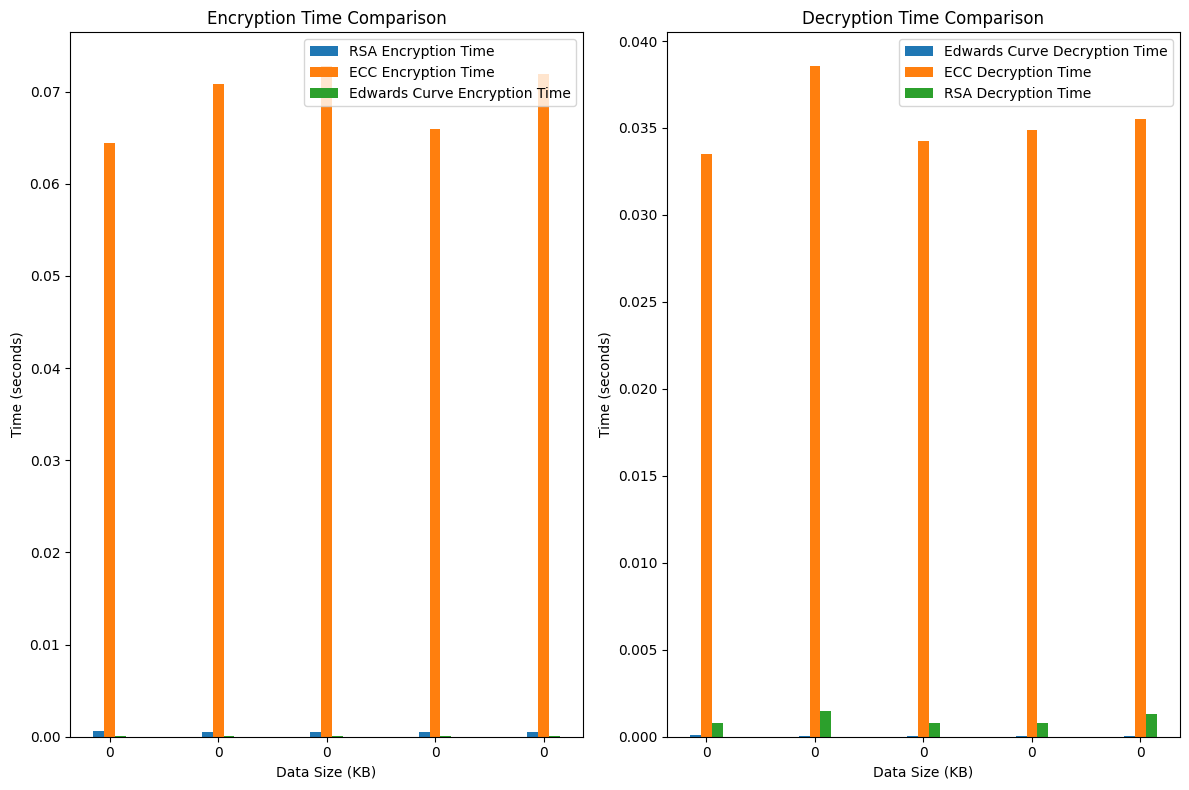

In [ ]:
import time
import random
import matplotlib.pyplot as plt
from Crypto.PublicKey import RSA
from Crypto.Cipher import PKCS1_OAEP
from tinyec import registry
from Crypto.Cipher import AES
import hashlib, secrets, binascii
import nacl.public
import nacl.utils
from nacl.public import PrivateKey, Box

# Simulate network metrics
def simulate_network_latency():
    latency = random.uniform(0.01, 0.1)  # Simulate latency between 10 to 100 milliseconds
    time.sleep(latency)

def simulate_network_jitter():
    base_latency = 0.05  # Average latency
    jitter = random.uniform(-0.01, 0.01)  # Jitter variation
    latency = base_latency + jitter
    time.sleep(latency)

def simulate_network_congestion():
    loss_rate = 0.05  # 5% packet loss rate
    is_packet_lost = random.random() < loss_rate
    if is_packet_lost:
        print("Packet lost due to congestion.")
    else:
        print("Packet successfully delivered.")

# ECC Encryption/Decryption
curve = registry.get_curve('brainpoolP256r1')

def ecc_encrypt(msg, pub_key):
    priv_key = secrets.randbelow(curve.field.n)
    shared_key = priv_key * pub_key
    secret_key = hashlib.sha256(int.to_bytes(shared_key.x, 32, 'big') + int.to_bytes(shared_key.y, 32, 'big')).digest()
    aes_cipher = AES.new(secret_key, AES.MODE_GCM)
    ciphertext, auth_tag = aes_cipher.encrypt_and_digest(msg)
    return (ciphertext, aes_cipher.nonce, auth_tag, priv_key * curve.g)

def ecc_decrypt(encrypted_msg, priv_key):
    ciphertext, nonce, auth_tag, pub_key = encrypted_msg
    shared_key = priv_key * pub_key
    secret_key = hashlib.sha256(int.to_bytes(shared_key.x, 32, 'big') + int.to_bytes(shared_key.y, 32, 'big')).digest()
    aes_cipher = AES.new(secret_key, AES.MODE_GCM, nonce)
    plaintext = aes_cipher.decrypt_and_verify(ciphertext, auth_tag)
    return plaintext

# Edwards Curve Encryption/Decryption
def edwards_encrypt(message, public_key, private_key):
    box = Box(private_key, public_key)
    encrypted = box.encrypt(message)
    return encrypted

def edwards_decrypt(encrypted_msg, private_key, public_key):
    box = Box(private_key, public_key)
    decrypted = box.decrypt(encrypted_msg)
    return decrypted

# RSA Encryption/Decryption
def rsa_encrypt(message, public_key):
    cipher_rsa = PKCS1_OAEP.new(public_key)
    encrypted = cipher_rsa.encrypt(message)
    return encrypted

def rsa_decrypt(encrypted_msg, private_key):
    cipher_rsa = PKCS1_OAEP.new(private_key)
    decrypted = cipher_rsa.decrypt(encrypted_msg)
    return decrypted

# Function to perform encryption and decryption with timing
def perform_encryption_decryption(data_size):
    message = b'A' * data_size  # Create a message of specified size

    # Simulate network conditions
    simulate_network_latency()
    simulate_network_jitter()
    simulate_network_congestion()

    # RSA Encryption
    rsa_key = RSA.generate(1024)
    rsa_public_key = rsa_key.publickey()
    start_time = time.time()
    rsa_encrypted = rsa_encrypt(message, rsa_public_key)
    rsa_encryption_time = time.time() - start_time



    # ECC Encryption
    ecc_private_key = secrets.randbelow(curve.field.n)
    ecc_public_key = ecc_private_key * curve.g
    start_time = time.time()
    ecc_encrypted = ecc_encrypt(rsa_encrypted, ecc_public_key)
    ecc_encryption_time = time.time() - start_time



    # Edwards Curve Encryption
    ed_private_key = PrivateKey.generate()
    ed_public_key = ed_private_key.public_key
    start_time = time.time()
    ed_encrypted = edwards_encrypt(ecc_encrypted[0], ed_public_key, ed_private_key)
    ed_encryption_time = time.time() - start_time

#data sent to reciever side

    # Decrypt with Edwards Curve
    start_time = time.time()
    ed_decrypted = edwards_decrypt(ed_encrypted, ed_private_key, ed_public_key)
    ed_decryption_time = time.time() - start_time


    # Decrypt with ECC
    start_time = time.time()
    ecc_decrypted = ecc_decrypt((ed_decrypted, ecc_encrypted[1], ecc_encrypted[2], ecc_encrypted[3]), ecc_private_key)
    ecc_decryption_time = time.time() - start_time


    # Decrypt with RSA
    start_time = time.time()
    rsa_decrypted = rsa_decrypt(ecc_decrypted, rsa_key)
    rsa_decryption_time = time.time() - start_time

    # Return encryption and decryption times
    return {
        'RSA Encryption Time': rsa_encryption_time,
        'ECC Encryption Time': ecc_encryption_time,
        'Edwards Curve Encryption Time': ed_encryption_time,
        'Edwards Curve Decryption Time': ed_decryption_time,
        'ECC Decryption Time': ecc_decryption_time,
        'RSA Decryption Time': rsa_decryption_time,
    }

# Test data sizes
data_sizes = [10,3000,5000,8000,16000]  # Sizes in bytes (3KB, 5KB, 8KB, 16KB)

# Perform tests and collect results
results = []
for size in data_sizes:
    results.append(perform_encryption_decryption(size))

# Print results
for idx, result in enumerate(results):
    print(f"Results for {data_sizes[idx] // 1024} KB data:")
    for key, value in result.items():
        print(f"{key}: {value:.6f} seconds")

# Plotting results
labels = ['RSA Encryption', 'ECC Encryption', 'Edwards Curve Encryption', 'Edwards Curve Decryption', 'ECC Decryption', 'RSA Decryption']
rsa_encryption_times = [result['RSA Encryption Time'] for result in results]
ecc_encryption_times = [result['ECC Encryption Time'] for result in results]
edwards_encryption_times = [result['Edwards Curve Encryption Time'] for result in results]
edwards_decryption_times = [result['Edwards Curve Decryption Time'] for result in results]
ecc_decryption_times = [result['ECC Decryption Time'] for result in results]
rsa_decryption_times = [result['RSA Decryption Time'] for result in results]

x = range(len(data_sizes))

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.bar(x, rsa_encryption_times, width=0.1, label='RSA Encryption Time')
plt.bar([p + 0.1 for p in x], ecc_encryption_times, width=0.1, label='ECC Encryption Time')
plt.bar([p + 0.2 for p in x], edwards_encryption_times, width=0.1, label='Edwards Curve Encryption Time')
plt.xticks([p + 0.1 for p in x], [size // 1024 for size in data_sizes])
plt.xlabel('Data Size (KB)')
plt.ylabel('Time (seconds)')
plt.title('Encryption Time Comparison')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(x, edwards_decryption_times, width=0.1, label='Edwards Curve Decryption Time')
plt.bar([p + 0.1 for p in x], ecc_decryption_times, width=0.1, label='ECC Decryption Time')
plt.bar([p + 0.2 for p in x], rsa_decryption_times, width=0.1, label='RSA Decryption Time')
plt.xticks([p + 0.1 for p in x], [size // 1024 for size in data_sizes])
plt.xlabel('Data Size (KB)')
plt.ylabel('Time (seconds)')
plt.title('Decryption Time Comparison')
plt.legend()

plt.tight_layout()
plt.show()
